In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import os
os.getcwd()
os.chdir('gdrive')
os.chdir('My Drive')
os.chdir('DeepResection')

!ls

'Copy of train_MAIN.ipynb'   model_mc_diff_params.h5	 model_vgg16.h5
 data			     model_mc.h5		 X_test_seg.npy
 model_1.h5		     model_resnet18.h5		 X_train_seg.npy
 model_2.h5		     model_resnet34.h5		 X_valid_seg.npy
 model_densenet.h5	     model_resnet50.h5		 Y_test_seg.npy
 model.h5		     model_test_val.h5		 Y_train_seg.npy
 model_mc_brightness.h5      model_vgg16_brightness.h5	 Y_valid_seg.npy


In [3]:
! pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-703kkk5r
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-703kkk5r
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp36-none-any.whl size=33792 sha256=d35d1fb78c75b7bab574f137edc5d65d3dac07f07346023e240a398df867e2ab
  Stored in directory: /tmp/pip-ephem-wheel-cache-xnsqa07c/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


After navigating to the right directory, implement the data preprocessing/generating code

In [0]:
import numpy as np
import glob
import os
import keras
from PIL import Image
from sklearn.model_selection import train_test_split

def getListOfImagePaths(dirPath):
    imagePaths = glob.glob('data/png/*/img/*')
    ret = [os.path.join(dirPath, os.path.normpath(path)) for path in imagePaths]
    return ret

def getListOfMaskPaths(imagePaths):
    ret = [p.replace('img/', 'mask/') for p in imagePaths]
    return ret

# dim is a tuple: (192, 192)
def getImagesForClassification(imagePaths, dim=(192, 192)):
    ret = np.empty((len(imagePaths), dim[0], dim[1], 3))
    index = 0
    for path in imagePaths:
        img = Image.open(path)
        img_arr = np.asarray(img)
        #crop image
        if(img_arr.shape[0] != dim[0]):
            toBeRemoved = img_arr.shape[0]-dim[0]
            toBeRemoved1 = int(np.ceil(toBeRemoved/2))
            toBeRemoved2 = int(np.floor(toBeRemoved/2))
            index1 = toBeRemoved1
            index2 = img_arr.shape[0]-toBeRemoved2
            img_arr = img_arr[index1:index2,:]
        if(img_arr.shape[1] != dim[1]):
            toBeRemoved = img_arr.shape[1]-dim[1]
            toBeRemoved1 = int(np.ceil(toBeRemoved/2))
            toBeRemoved2 = int(np.floor(toBeRemoved/2))
            index1 = toBeRemoved1
            index2 = img_arr.shape[1]-toBeRemoved2
            img_arr = img_arr[:,index1:index2]
        #add image to returned array
        ret[index,:,:,0] = img_arr
        ret[index,:,:,1] = img_arr
        ret[index,:,:,2] = img_arr
        index=index+1
    return ret

# returns numpy vector where each entry is 0 or 1 based on whether the image contains resected tissue
def getClassificationY(maskPaths):
    num_masks = len(maskPaths)
    Y = np.zeros(num_masks)
    index = 0
    for path in imagePaths:
        img = Image.open(path)
        img_arr = np.asarray(img)
        #crop image
        if(img_arr.shape[0] != dim[0]):
            toBeRemoved = img_arr.shape[0]-dim[0]
            toBeRemoved1 = int(np.ceil(toBeRemoved/2))
            toBeRemoved2 = int(np.floor(toBeRemoved/2))
            index1 = toBeRemoved1
            index2 = img_arr.shape[0]-toBeRemoved2
            img_arr = img_arr[index1:index2,:]
        if(img_arr.shape[1] != dim[1]):
            toBeRemoved = img_arr.shape[1]-dim[1]
            toBeRemoved1 = int(np.ceil(toBeRemoved/2))
            toBeRemoved2 = int(np.floor(toBeRemoved/2))
            index1 = toBeRemoved1
            index2 = img_arr.shape[1]-toBeRemoved2
            img_arr = img_arr[:,index1:index2]
        Y[index] = 1 if np.any(img_arr) else 0
        index=index+1
    return Y

# dim is a tuple: (256, 256)
def getImagesForSegmentation(imagePaths, dim=(256,256)):
    ret = np.empty((len(imagePaths), dim[0], dim[1]))
    index = 0
    for path in imagePaths:
        img = Image.open(path)
        img_arr = np.asarray(img)
        #pad image
        if(img_arr.shape[0] != dim[0]):
            toBeAdded = dim[0] - img_arr.shape[0]
            toBeAdded1 = int(np.ceil(toBeAdded/2))
            toBeAdded2 = int(np.floor(toBeAdded/2))
            img_arr = np.pad(img_arr, ((toBeAdded1, toBeAdded2), (0, 0)))
        if(img_arr.shape[1] != dim[1]):
            toBeAdded = dim[1] - img_arr.shape[1]
            toBeAdded1 = int(np.ceil(toBeAdded/2))
            toBeAdded2 = int(np.floor(toBeAdded/2))
            img_arr = np.pad(img_arr, ((0, 0), (toBeAdded1, toBeAdded2)))
        #add image to returned array
        ret[index,:,:] = img_arr
        index=index+1
    return ret


dirPath = os.getcwd()
imagePaths = getListOfImagePaths(dirPath)
maskPaths = getListOfMaskPaths(imagePaths)

# define the training, validation, and test patients
imagePaths_valid = []
for path in imagePaths:
    if '14_w' in path or '23_r' in path or '27_m' in path or 'pat05' in path or 'pat11' in path or 'pat15' in path or 'pat20' in path:
        imagePaths_valid.append(path)
maskPaths_valid = getListOfMaskPaths(imagePaths_valid)
imagePaths_test = []
for path in imagePaths:
    if '24_c' in path or '40_f' in path or '42_m' in path or 'pat03' in path or 'pat06' in path or 'pat25' in path or 'pat30' in path:
        imagePaths_test.append(path)
maskPaths_test = getListOfMaskPaths(imagePaths_test)
imagePaths_train = []
for path in imagePaths:
    if path not in imagePaths_valid and path not in imagePaths_test:
        imagePaths_train.append(path)
maskPaths_train = getListOfMaskPaths(imagePaths_train)

# get X and Y for each set, for the classification of images containing and not containing resected tissue
X_train_class = getImagesForClassification(imagePaths_train)
X_train_class = X_train_class/255
X_valid_class = getImagesForClassification(imagePaths_valid)
X_valid_class = X_valid_class/255
X_test_class = getImagesForClassification(imagePaths_test)
X_test_class = X_test_class/255
Y_train_class = getClassificationY(maskPaths_train)
Y_valid_class = getClassificationY(maskPaths_valid)
Y_test_class = getClassificationY(maskPaths_test)

# get X and Y for each set, for the segmentation of resected tissue in images
X_train_seg = getImagesForSegmentation(imagePaths_train)
X_train_seg = X_train_seg/255
X_train_seg = X_train_seg[..., np.newaxis]
X_valid_seg = getImagesForSegmentation(imagePaths_valid)
X_valid_seg = X_valid_seg/255
X_valid_seg = X_valid_seg[..., np.newaxis]
X_test_seg = getImagesForSegmentation(imagePaths_test)
X_test_seg = X_test_seg/255
X_test_seg = X_test_seg[..., np.newaxis]
Y_train_seg = getImagesForSegmentation(maskPaths_train)
Y_train_seg = Y_train_seg/255
Y_train_seg = (Y_train_seg > 0).astype(np.float32)
Y_train_seg = Y_train_seg[..., np.newaxis]
Y_valid_seg = getImagesForSegmentation(maskPaths_valid)
Y_valid_seg = Y_valid_seg/255
Y_valid_seg = (Y_valid_seg > 0).astype(np.float32)
Y_valid_seg = Y_valid_seg[..., np.newaxis]
Y_test_seg = getImagesForSegmentation(maskPaths_test)
Y_test_seg = Y_test_seg/255
Y_test_seg = (Y_test_seg > 0).astype(np.float32)
Y_test_seg = Y_test_seg[..., np.newaxis]

Save dataset to npy files

In [0]:
np.save('X_train_class.npy', X_train_class)
np.save('Y_train_class.npy', Y_train_class)
np.save('X_valid_class.npy', X_valid_class)
np.save('Y_valid_class.npy', Y_valid_class)
np.save('X_test_class.npy', X_test_class)
np.save('Y_test_class.npy', Y_test_class)

np.save('X_train_seg.npy', X_train_seg)
np.save('Y_train_seg.npy', Y_train_seg)
np.save('X_valid_seg.npy', X_valid_seg)
np.save('Y_valid_seg.npy', Y_valid_seg)
np.save('X_test_seg.npy', X_test_seg)
np.save('Y_test_seg.npy', Y_test_seg)

Load dataset from npy files

In [0]:
import numpy as np

X_train_seg = np.load('X_train_seg.npy')
Y_train_seg = np.load('Y_train_seg.npy')
X_valid_seg = np.load('X_valid_seg.npy')
Y_valid_seg = np.load('Y_valid_seg.npy')
X_test_seg = np.load('X_test_seg.npy')
Y_test_seg = np.load('Y_test_seg.npy')

Implement data augmentation on the training data, increasing model's generalizability



In [0]:
from tensorflow.keras.preprocessing.image import random_brightness

(num_train_samples, _, _, _) = X_train_seg.shape
X_train_seg_b = np.zeros(X_train_seg.shape)

for i in range(0, num_train_samples):
    img = X_train_seg[i,:,:,:]
    img_b = random_brightness(img, brightness_range=(0.7, 1.3))
    X_train_seg_b[i,:,:,:] = img_b

X_train_seg_b = X_train_seg_b/255

In [6]:
from keras.preprocessing.image import ImageDataGenerator

seed = 909
datagen_args = dict(rotation_range = 10, width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True, vertical_flip = True)
#mask_args = dict(rotation_range = 10, width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True, vertical_flip = True)
image_datagen = ImageDataGenerator(**datagen_args)
mask_datagen = ImageDataGenerator(**datagen_args)

image_datagen.fit(X_train_seg_b, augment = True, seed = seed)
mask_datagen.fit(Y_train_seg, augment = True, seed = seed)

image_generator = image_datagen.flow(X_train_seg_b, seed = seed, batch_size=1)
mask_generator = mask_datagen.flow(Y_train_seg, seed = seed, batch_size=1)
train_generator = (pair for pair in zip(image_generator, mask_generator))

(num_train_samples, _, _, _) = X_train_seg.shape

Using TensorFlow backend.


In [0]:
X_train_seg_f = np.zeros(X_train_seg.shape)
Y_train_seg_f = np.zeros(Y_train_seg.shape)

for step in range(0, num_train_samples):
    X_batch, Y_batch = next(train_generator)
    X_train_seg_f[step,:,:,:] = X_batch[0,:,:,:]
    Y_train_seg_f[step,:,:,:] = np.round(Y_batch[0,:,:,:])

Build general model with ImageNet starting weights

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.densenet import DenseNet121

def generate_classification_model():

    # use pre-trained weights on ImageNet as starting weights
    model = DenseNet121(include_top=False, weights='imagenet', input_shape=(192,192,3), pooling=max)

    # add sigmoid activation layer
    top_model = GlobalAveragePooling2D(input_shape=(192,192,3)) (model.layers[-1].output)
    top_model2 = Dense(1, activation='sigmoid') (top_model)

    new_model = Model(inputs=model.input, outputs=top_model2)
    
    adm = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    new_model.compile(loss='binary_crossentropy', optimizer=adm, metrics=['binary_accuracy'])
    return new_model

Train and test the model

In [0]:
# run from DeepResection directory
current_dir = os.getcwd()

data_generator = DataGenerator(current_dir)

model_detect_resection = generate_classification_model()

model_detect_resection.summary()

num_epochs = 10

batch_size = 32

X_train, Y_train = data_generator.getTrainDataForClassification()
X_test, Y_test = data_generator.getTestDataForClassification()

model_detect_resection.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs)
score=model_detect_resection.evaluate(X_test, Y_test)

print('metrics: ')
print(model_detect_resection.metrics_names)
print('scores:')
print(score)

Calculate and plot the ROC curve for the binary classification problem

auc: 
0.9979393599757159


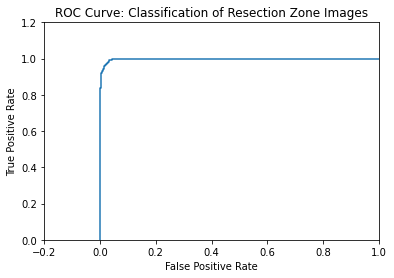

In [0]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

Y_score = model_detect_resection.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_score)
auc = roc_auc_score(Y_test, Y_score)
print('auc: ')
print(auc)

plt.plot(fpr, tpr)
plt.axis([-0.1, 1, 0, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Classification of Resection Zone Images')
plt.show()

Generate the U-Net segmentation model (this code does it from scratch)



In [0]:
from keras.applications import VGG16
from keras import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.optimizers import Adam
from keras.utils import get_custom_objects
import tensorflow.keras.backend as K

def dice_coeff(y_true, y_pred):
    epsilon = 10 ** -7
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred)
    dice_score = (2.0 * intersection + epsilon) / (union + epsilon)
    return dice_score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def generate_segmentation_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv5))
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid', padding='same', kernel_initializer='he_normal')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss=dice_loss, metrics=[dice_coeff])
    return model

def generate_segmentation_model_pretrained(input_size=(256, 256, 3)):
    model_weights = VGG16(include_top = False, input_shape = (256, 256, 3), weights='imagenet', pooling=max)
    layers = model_weights.layers

    conv1 = layers[2].output
    conv2 = layers[5].output
    conv3 = layers[9].output
    conv4 = layers[13].output
    conv5 = layers[17].output

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv5))
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid', padding='same', kernel_initializer='he_normal')(conv9)

    model = Model(inputs = model_weights.inputs, outputs = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss='dice', metrics=[dice_coeff])
    return model

Magician's Corner code (copied and pasted)

In [0]:
import numpy as np
import numpy.ma as ma
import os
import shutil
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dense, Dropout, Activation, Flatten, BatchNormalization, Reshape
from keras.engine.topology import Layer

from keras.layers.merge import concatenate, add
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import imageio
from natsort import natsorted
import random
import warnings
warnings.filterwarnings("ignore")

def dice_coeff(y_true, y_pred):
    # add epsilon to avoid a divide by 0 error in case a slice has no pixels set
    # we only care about relative value, not absolute so this alteration doesn't matter
    _epsilon = 10 ** -7
    intersections = tf.reduce_sum(y_true * y_pred)
    unions = tf.reduce_sum(y_true + y_pred)
    dice_scores = (2.0 * intersections + _epsilon) / (unions + _epsilon)
    return dice_scores

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss
  
get_custom_objects().update({"dice": dice_loss})

class LayerNormalization (Layer) :
    
    def call(self, x, mask=None, training=None) :
        axis = list (range (1, len (x.shape)))
        x /= K.std (x, axis = axis, keepdims = True) + K.epsilon()
        x -= K.mean (x, axis = axis, keepdims = True)
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape

def build_model(act_fn = 'relu', init_fn = 'he_normal', width=256, height = 256, channels = 1): 
    inputs = Input((width,height,channels))

    # note we use linear function before layer normalization
    conv1 = Conv2D(8, 5, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(inputs)
    conv1 = LayerNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(16, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(32, 3, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(pool2)
    conv3 = LayerNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(64, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(72, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(pool4)

    up6 = Conv2D(64, 2, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv5))
    up6 = LayerNormalization()(up6)
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(64, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge6)

    up7 = Conv2D(32, 2, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(32, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge7)

    up8 = Conv2D(16, 2, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv7))
    up8 = LayerNormalization()(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(16, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge8)

    up9 = Conv2D(8, 2, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(8, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'dice', metrics=[dice_coeff])
    return model

Display the training data after data augmentation

[0. 1.]


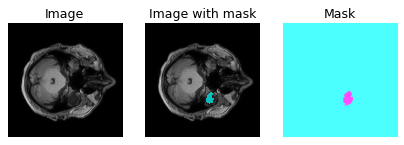

In [0]:
import matplotlib.pyplot as plt
import numpy.ma as ma

fig=plt.figure(figsize=(130, 130), dpi = 75)

#i=0
while np.sum(Y_train_seg_f[i,:,:,0]) < 200:
    i = i+1

X = X_train_seg_f[i,:,:,0]
Y = Y_train_seg_f[i,:,:,0]
print(np.unique(Y))

mask = ma.masked_where(Y != 1.0, Y)
    
fig.add_subplot(3, 3, 1)
plt.imshow(X, cmap = "gray")
plt.title("Image")
plt.axis('off')

fig.add_subplot(3, 3, 2)
plt.imshow(X, cmap = "gray")
plt.imshow(mask, 'cool', alpha=0.7)
plt.title("Image with mask")
plt.axis('off')

fig.add_subplot(3, 3, 3)
plt.imshow(Y, 'cool', alpha=0.7)
plt.title("Mask")
plt.axis('off')
    
plt.subplots_adjust(bottom=0.1, left = 0.01, right=0.05, top=0.3)
plt.show()
i=i+20

Train the particular model we are testing

In [0]:
import segmentation_models as sm

num_epochs = 35

batch_size = 64

BACKBONE = 'resnet50'

base_model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=1, activation='sigmoid')
inp = Input(shape=(256, 256, 1))
l1 = Conv2D(3, (1, 1)) (inp)
out = base_model(l1)
model = Model(inp, out, name = base_model.name)
checkpointer = ModelCheckpoint('model_resnet50_brightness.h5', verbose=1, save_best_only=True)
model.compile(optimizer = Adam(lr = 1e-4), loss=dice_loss, metrics=[dice_coeff])
steps_per_epoch = np.ceil(num_train_samples/64.0)
batch_size = 16
results = model.fit(X_train_seg_f, Y_train_seg_f, validation_data = (X_valid_seg, Y_valid_seg), batch_size=batch_size, epochs = num_epochs, callbacks=[checkpointer])

94593024/94592056 [==============================] - 7s 0us/step
Train on 3530 samples, validate on 1080 samples
Epoch 1/35
3530/3530 [==============================] - 327s 93ms/step - loss: 0.9706 - dice_coeff: 0.0295 - val_loss: 0.9966 - val_dice_coeff: 0.0034

Epoch 00001: val_loss improved from inf to 0.99659, saving model to model_resnet50_brightness.h5
Epoch 2/35
3530/3530 [==============================] - 304s 86ms/step - loss: 0.8470 - dice_coeff: 0.1534 - val_loss: 0.9985 - val_dice_coeff: 0.0015

Epoch 00002: val_loss did not improve from 0.99659
Epoch 3/35
3530/3530 [==============================] - 304s 86ms/step - loss: 0.5899 - dice_coeff: 0.4094 - val_loss: 0.9997 - val_dice_coeff: 3.0609e-04

Epoch 00003: val_loss did not improve from 0.99659
Epoch 4/35
3530/3530 [==============================] - 303s 86ms/step - loss: 0.4146 - dice_coeff: 0.5852 - val_loss: 0.9958 - val_dice_coeff: 0.0041

Epoch 00004: val_loss improved from 0.99659 to 0.99583, saving model to mode

Test the particular model we are testing, by calculating the dice score from the predicted masks, and displaying several examples containing predicted masks and corresponding ground truth masks

1080/1080 [==============================] - 19s 18ms/step
























































































































































































































































































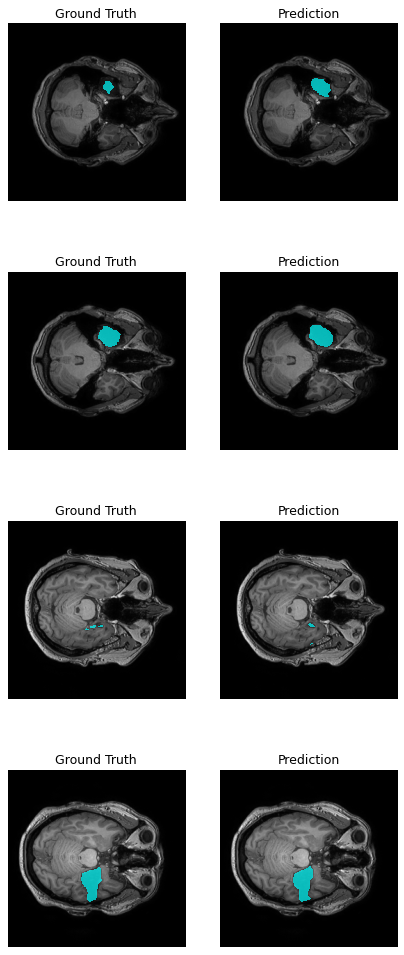

The dice score for this model is:  0.785336856010568


In [24]:
model.load_weights('./model_vgg16_brightness.h5')
preds_test = model.predict(X_test_seg, verbose=1)
preds_test = (preds_test > 0.5).astype(np.uint8)

def np_dice(true, pred):
    intersection = np.sum(true * pred)
    dc =(2.0 * intersection) / (np.sum(true) + np.sum(pred))
    return dc

fig=plt.figure(figsize=(130, 130), dpi = 75)

i=0
for j in range(0,8,2):
    while np.sum(Y_test_seg[i,:,:,0]) < 50:
        i = i+1
        print()
    image = X_test_seg[i,...,0]
    mask =  Y_test_seg[i,...,0]
    mask = ma.masked_where(mask == 0, mask)
    pred = preds_test[i,...,0]
    pred = ma.masked_where(pred == 0, pred)
    
    fig.add_subplot(8, 2, j+1)
    plt.imshow(image, cmap = "gray")
    plt.imshow(mask, 'cool', alpha=0.7)
    plt.title("Ground Truth")
    plt.axis('off')
    
    fig.add_subplot(8, 2, j+2)
    plt.imshow(image, cmap = "gray")
    plt.imshow(pred, 'cool', alpha=0.7)
    plt.title("Prediction")
    plt.axis('off')
    i = i+20
    
plt.subplots_adjust(bottom=0.1, left = 0.01, right=0.05, top=0.3)
plt.show()

print("The dice score for this model is: ", np_dice(Y_test_seg, preds_test))

Run this to reset variables when debugging

In [0]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
